**Se prepara el entorno de trabajo para llevar a cabo las fases: exploratoria, preprocesamiento y embeddings**

In [ ]:
import pandas as pd
import nltk
import spacy
from nltk.tokenize import word_tokenize
from spacy.lang.es.stop_words import STOP_WORDS as stopwords_spacy
import re
import numpy as np
import matplotlib.pyplot as plt
from transformers import BertTokenizer, BertModel
import torch

In [ ]:
# Descargar datos necesarios
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('stopwords')

# Cargar modelo de spaCy para español
!python -m spacy download es_core_news_sm
import es_core_news_sm
nlp = es_core_news_sm.load()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.9/12.9 MB 30.4 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('es_core_news_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
# Cargar el modelo preentrenado BETO
tokenizer = BertTokenizer.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')
model = BertModel.from_pretrained('dccuchile/bert-base-spanish-wwm-uncased')


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertModel were not initialized from the model checkpoint at dccuchile/bert-base-spanish-wwm-uncased and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Leer archivo Excel
df = pd.read_excel('/content/datosUnificados.xlsx')

# Verificar las columnas disponibles
print("Columnas disponibles en el DataFrame:", df.columns)

# Asegurarse de que los nombres de las columnas no tengan espacios extra
df.columns = df.columns.str.strip()

Columnas disponibles en el DataFrame: Index(['Nombre del archivo', 'ID', 'NER_personas', 'NER-Organizaciones',
       'NER Fechas', 'Hechos ', 'Pretensiones', 'Consideraciones 1',
       'Consideraciones 2', 'Consideraciones 3', 'Consideraciones 4',
       'Sección resuelve', 'Trigramas_texto', 'Trigramas_relevantes',
       'Etiqueta'],
      dtype='object')


**Preprocesamiento **


In [ ]:
# Funciones de preprocesamiento
def preprocess_text(text):
    # Tokenizar
    tokens = word_tokenize(text)
    # Convertir a minúsculas
    tokens = [token.lower() for token in tokens]
    # Eliminar números y signos especiales
    tokens = [re.sub(r'\W+', '', token) for token in tokens if re.sub(r'\W+', '', token)]
    # Eliminar stopwords
    tokens = [token for token in tokens if token not in stopwords_spacy]
    # Lematizar
    doc = nlp(' '.join(tokens))
    tokens = [token.lemma_ for token in doc]
    return tokens

**Ejecución y Embeddings**

In [ ]:
# Aplicar preprocesamiento a las columnas "Hechos" y "Pretensiones"
if 'Hechos' in df.columns and 'Pretensiones' in df.columns:
    df['Hechos_tokens'] = df['Hechos'].apply(preprocess_text)
    df['Pretensiones_tokens'] = df['Pretensiones'].apply(preprocess_text)

    # Contar el número de palabras por cada fila
    df['Hechos_word_count'] = df['Hechos_tokens'].apply(len)
    df['Pretensiones_word_count'] = df['Pretensiones_tokens'].apply(len)

    # Identificar las 10 palabras más frecuentes en cada fila
    def get_top_n_words(tokens, n=10):
        freq_dist = nltk.FreqDist(tokens)
        common_words = [word for word, freq in freq_dist.most_common(n)]
        return common_words

    df['Hechos_top_words'] = df['Hechos_tokens'].apply(get_top_n_words)
    df['Pretensiones_top_words'] = df['Pretensiones_tokens'].apply(get_top_n_words)

    # Identificar los 10 NER principales
    def get_top_n_entities(text, n=10):
        doc = nlp(text)
        entities = [ent.text for ent in doc.ents]
        freq_dist = nltk.FreqDist(entities)
        common_entities = [entity for entity, freq in freq_dist.most_common(n)]
        return common_entities

    df['Hechos_top_entities'] = df['Hechos'].apply(get_top_n_entities)
    df['Pretensiones_top_entities'] = df['Pretensiones'].apply(get_top_n_entities)

    # Generar etiquetado gramatical
    df['Hechos_pos_tags'] = df['Hechos_tokens'].apply(nltk.pos_tag)
    df['Pretensiones_pos_tags'] = df['Pretensiones_tokens'].apply(nltk.pos_tag)

    # Graficar el etiquetado gramatical
    def plot_pos_tags(pos_tags, title):
        tags = [tag for word, tag in pos_tags]
        freq_dist = nltk.FreqDist(tags)
        plt.figure(figsize=(10, 5))
        freq_dist.plot(30, title=title)

    # Normalizar la extensión de los textos
    mean_length_hechos = df['Hechos_word_count'].mean()
    mean_length_pretensiones = df['Pretensiones_word_count'].mean()

    df['Hechos_normalized_length'] = df['Hechos_word_count'] / mean_length_hechos
    df['Pretensiones_normalized_length'] = df['Pretensiones_word_count'] / mean_length_pretensiones

    # Generar embeddings con BETO y asegurarse de que tengan la misma longitud
    def get_bert_embeddings(text, tokenizer, model):
        inputs = tokenizer(text, return_tensors='pt', truncation=True, padding='max_length', max_length=512)
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state.mean(dim=1).detach().numpy()
        return embeddings.flatten()

    df['Hechos_embeddings'] = df['Hechos'].apply(lambda x: get_bert_embeddings(x, tokenizer, model))
    df['Pretensiones_embeddings'] = df['Pretensiones'].apply(lambda x: get_bert_embeddings(x, tokenizer, model))

    # Convertir los embeddings a DataFrame separado para cada columna
    hechos_embeddings_df = pd.DataFrame(df['Hechos_embeddings'].tolist(), index=df.index)
    pretensiones_embeddings_df = pd.DataFrame(df['Pretensiones_embeddings'].tolist(), index=df.index)

    # Combinar los DataFrames de embeddings con el DataFrame original
    df_embeddings = pd.concat([df, hechos_embeddings_df, pretensiones_embeddings_df], axis=1)

    # Imprimir resultados
    print(df_embeddings[['Hechos_word_count', 'Pretensiones_word_count', 'Hechos_top_words', 'Pretensiones_top_words', 'Hechos_top_entities', 'Pretensiones_top_entities', 'Hechos_pos_tags', 'Pretensiones_pos_tags']])

    # Guardar resultados en un nuevo archivo Excel
    df_embeddings.to_excel('/content/resultadosAnalisis.xlsx', index=False)
else:
    print("Las columnas 'Hechos' y 'Pretensiones' no se encontraron en el archivo Excel.")

     Hechos_word_count  Pretensiones_word_count  \
0                   60                       53   
1                   68                      120   
2                   92                      375   
3                 2225                       45   
4                   45                       22   
..                 ...                      ...   
159                 19                       42   
160                 19                       42   
161                 25                       35   
162                 33                       25   
163                 27                       50   

                                      Hechos_top_words  \
0    [proceso, barragán, 2020, 3, despacho, iniciad...   
1    [sociedad, conflicto, interés, administrador, ...   
2    [acción, servisatélite, stephenson, carlos, he...   
3    [sociedad, muñoz, accionista, proyecto, legal,...   
4    [fe, jorge, hakim, acción, jurídico, malo, evi...   
..                                     

**Visualización**

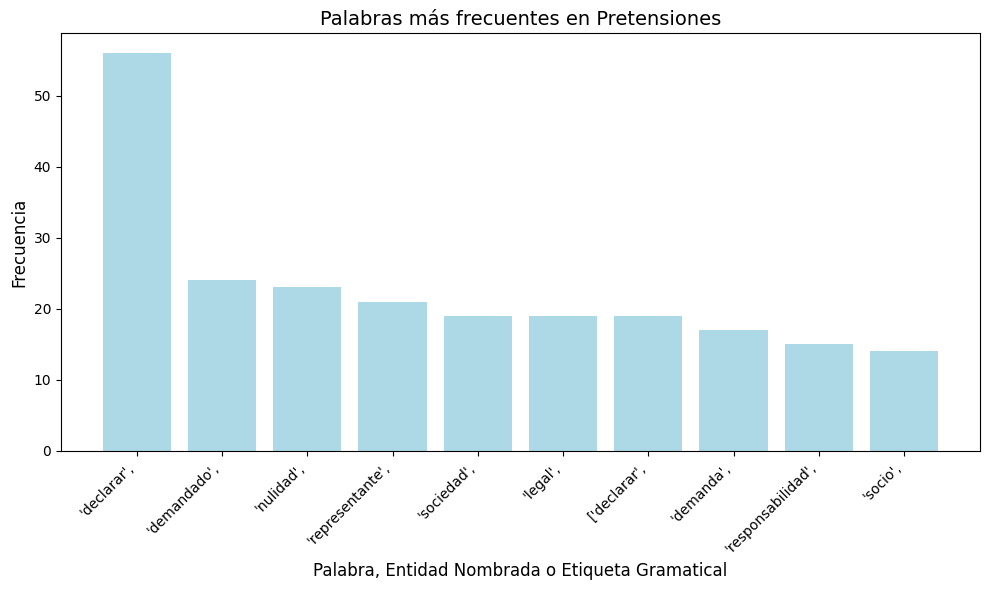

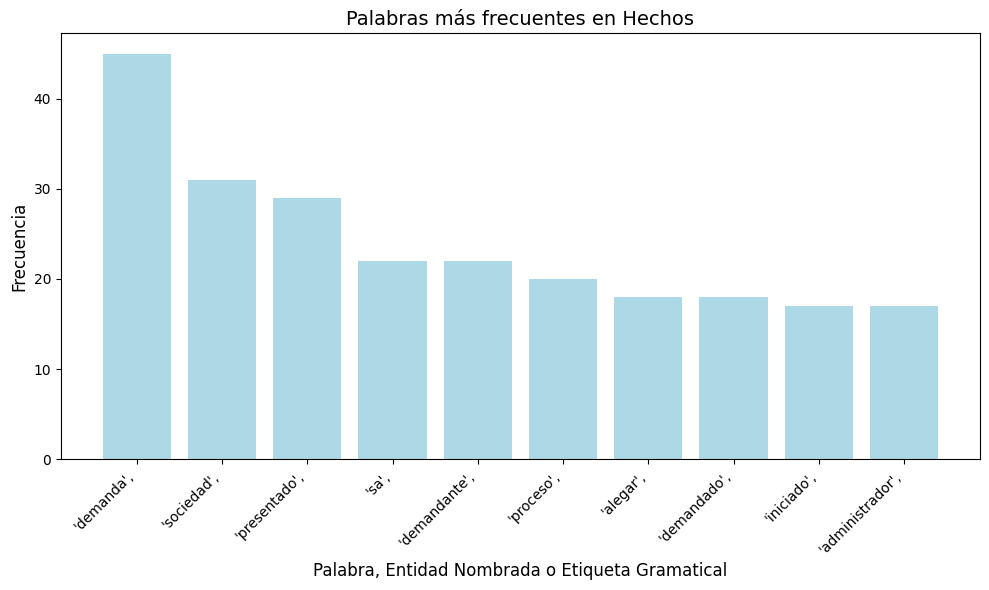

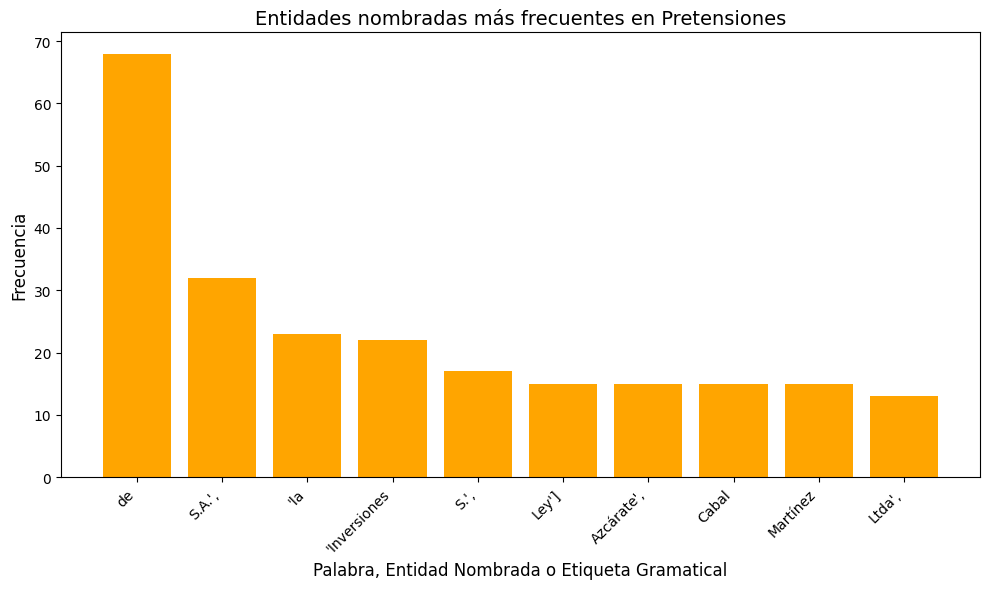

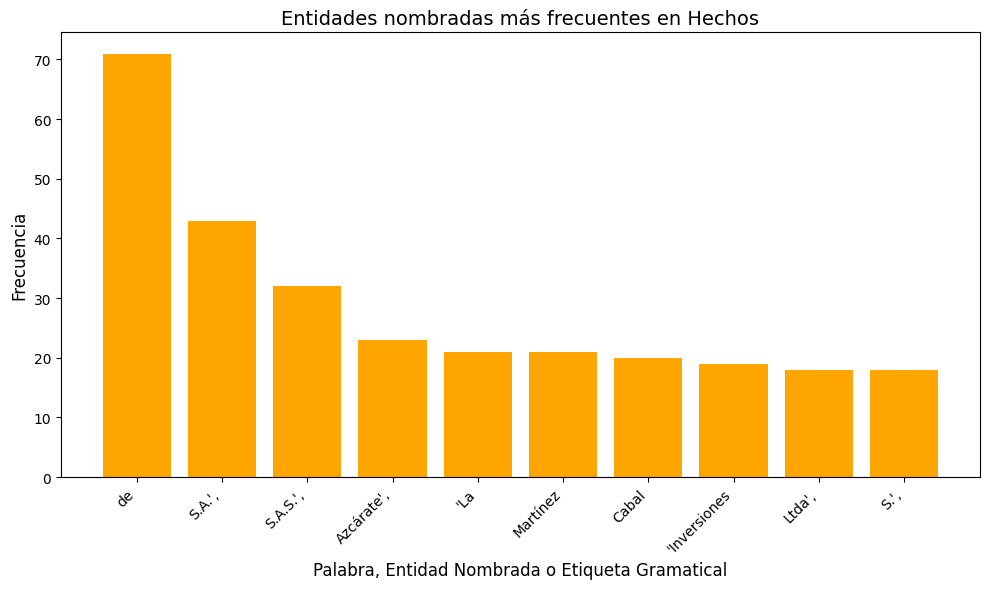

In [ ]:
import pandas as pd
import nltk
import matplotlib.pyplot as plt

# Leer el archivo de resultados previamente guardado
df = pd.read_excel('/content/resultadosAnalisis.xlsx')

# Función para calcular las principales palabras y entidades nombradas y graficarlas
def plot_top_n(data, column_name, n=10, title=None, color='lightblue'):
    # Obtener los datos de la columna específica
    column_data = data[column_name]

    # Verificar si los datos son palabras o entidades nombradas
    if 'words' in column_name:
        all_items = [word for sublist in column_data for word in sublist.split()]
    elif 'entities' in column_name:
        all_items = [entity for sublist in column_data for entity in sublist.split()]
    elif 'pos_tags' in column_name:
        tags = [tag[1] for sublist in column_data for tag in sublist if len(tag) == 2]
        freq_dist = nltk.FreqDist(tags)
        top_items = dict(freq_dist.most_common(n))
    else:
        raise ValueError("Column name should contain 'words', 'entities', or 'pos_tags'.")

    # Calcular las principales palabras o entidades nombradas
    freq_dist = nltk.FreqDist(all_items)
    top_items = dict(freq_dist.most_common(n))

    # Crear la gráfica de barras
    plt.figure(figsize=(10, 6))
    plt.bar(top_items.keys(), top_items.values(), color=color)
    plt.xlabel('Palabra, Entidad Nombrada o Etiqueta Gramatical', fontsize=12)
    plt.ylabel('Frecuencia', fontsize=12)
    plt.title(title if title else f'Top {n} principales en {column_name}', fontsize=14)
    plt.xticks(rotation=45, ha='right', fontsize=10)
    plt.yticks(fontsize=10)
    plt.tight_layout()
    plt.show()

# Graficar las 10 principales palabras en Pretensiones y Hechos
plot_top_n(df, 'Pretensiones_top_words', n=10, title='Palabras más frecuentes en Pretensiones', color='lightblue')
plot_top_n(df, 'Hechos_top_words', n=10, title='Palabras más frecuentes en Hechos', color='lightblue')

# Graficar las 10 principales entidades nombradas en Pretensiones y Hechos
plot_top_n(df, 'Pretensiones_top_entities', n=10, title='Entidades nombradas más frecuentes en Pretensiones', color='orange')
plot_top_n(df, 'Hechos_top_entities', n=10, title='Entidades nombradas más frecuentes en Hechos', color='orange')
